In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Creating windowes dataset sing tensorflow API

In [2]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))

In [3]:
for window in dataset:
    print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [4]:
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [5]:
for x, y in dataset:
    print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [6]:
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)

In [7]:
for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())

x =  [[5 6 7 8]
 [3 4 5 6]]
y =  [[9]
 [7]]
x =  [[2 3 4 5]
 [0 1 2 3]]
y =  [[6]
 [4]]
x =  [[4 5 6 7]
 [1 2 3 4]]
y =  [[8]
 [5]]


Synthetic time series data

In [8]:
def trend(time, slope=0):
    return slope * time

def seasonal_patter(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1/np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_patter(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [9]:
time = np.arange(4 * 365 + 1, dtype="float32")
series = trend(time, 0.1)
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

series = baseline + trend(time, slope) 
series += seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=42)

In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1,drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window:(window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [11]:
split_time = 1000
time_train = time[:split_time]

x_train = series[:split_time]
time_valid = time[split_time:]

x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [12]:
dataset = windowed_dataset(x_train, window_size, batch_size,shuffle_buffer_size)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [13]:
for feature, label in dataset.take(1):
    print(feature)
    print(label)

tf.Tensor(
[[ 30.965899    25.972609    38.917446    32.00232     23.72159
   33.0062      24.89571     33.750595    35.65456     25.80494
   34.77235     32.066845    34.161064    39.582893    28.920498
   26.427605    25.797895    26.215937    29.959328    32.100777  ]
 [ 91.40173     83.24676     93.49553     92.1787      92.288055
   84.33344     85.09616     95.54879     89.86424     93.24602
   89.7542      89.53318     93.84538     86.341194    89.16745
   86.13896     86.03953     86.42608     88.840904    85.093254  ]
 [ 61.099957    51.07409     44.60956     40.246727    36.76993
   45.599754    40.583595    37.03971     40.706562    38.32304
   51.96083     47.730747    43.08328     50.326706    43.12101
   38.238354    49.9745      44.871124    36.811703    40.87135   ]
 [ 96.932556    91.64963     99.37076     92.913605    96.319275
  108.421974    95.04854    101.17749     91.812584    95.04598
  103.96257     91.8566     103.93184     98.28189     91.79975
   97.63857   

create DNN to fit the data


In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [29]:
lr = 1e-5

In [30]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=lr,momentum=0.9))

In [31]:
model.fit(dataset,epochs=100,verbose=2)

Epoch 1/100
31/31 - 0s - loss: 744.1904
Epoch 2/100
31/31 - 0s - loss: 725.6570
Epoch 3/100
31/31 - 0s - loss: 722.2806
Epoch 4/100
31/31 - 0s - loss: 721.2341
Epoch 5/100
31/31 - 0s - loss: 720.8834
Epoch 6/100
31/31 - 0s - loss: 720.8852
Epoch 7/100
31/31 - 0s - loss: 720.9137
Epoch 8/100
31/31 - 0s - loss: 720.8353
Epoch 9/100
31/31 - 0s - loss: 720.9078
Epoch 10/100
31/31 - 0s - loss: 720.9373
Epoch 11/100
31/31 - 0s - loss: 720.8442
Epoch 12/100
31/31 - 0s - loss: 720.8242
Epoch 13/100
31/31 - 0s - loss: 720.8795
Epoch 14/100
31/31 - 0s - loss: 720.8588
Epoch 15/100
31/31 - 0s - loss: 720.8724
Epoch 16/100
31/31 - 0s - loss: 720.9382
Epoch 17/100
31/31 - 0s - loss: 721.1851
Epoch 18/100
31/31 - 0s - loss: 720.8646
Epoch 19/100
31/31 - 0s - loss: 720.8719
Epoch 20/100
31/31 - 0s - loss: 720.8873
Epoch 21/100
31/31 - 0s - loss: 720.7749
Epoch 22/100
31/31 - 0s - loss: 720.8099
Epoch 23/100
31/31 - 0s - loss: 720.9460
Epoch 24/100
31/31 - 0s - loss: 720.8210
Epoch 25/100
31/31 - 0s -

In [32]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(
        model.predict(series[time:time + window_size][np.newaxis])
    )

In [33]:
forecast

[array([[59.380383]], dtype=float32),
 array([[59.380383]], dtype=float32),
 array([[59.380383]], dtype=float32),
 array([[59.380383]], dtype=float32),
 array([[59.380383]], dtype=float32),
 array([[59.380383]], dtype=float32),
 array([[59.380383]], dtype=float32),
 array([[59.380383]], dtype=float32),
 array([[59.380383]], dtype=float32),
 array([[59.380383]], dtype=float32),
 array([[59.380383]], dtype=float32),
 array([[59.380383]], dtype=float32),
 array([[59.380383]], dtype=float32),
 array([[59.380383]], dtype=float32),
 array([[59.380383]], dtype=float32),
 array([[59.380383]], dtype=float32),
 array([[59.380383]], dtype=float32),
 array([[59.380383]], dtype=float32),
 array([[59.380383]], dtype=float32),
 array([[59.380383]], dtype=float32),
 array([[59.380383]], dtype=float32),
 array([[59.380383]], dtype=float32),
 array([[59.380383]], dtype=float32),
 array([[59.380383]], dtype=float32),
 array([[59.380383]], dtype=float32),
 array([[59.380383]], dtype=float32),
 array([[59.

In [34]:
forecast = forecast[split_time-window_size:]


In [35]:
results = np.array(forecast)[:, 0, 0]

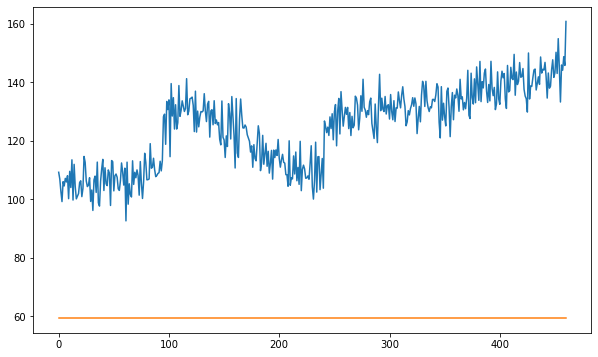

In [36]:
plt.figure(figsize=(10, 6))

plt.plot(series[split_time:], label="Series")
plt.plot(results, label="Forecast")
plt.show()

In [37]:
tf.keras.metrics.mean_squared_error(x_valid, results).numpy()

4409.948

Tuning the learning rate using callback.

In [38]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch /20)
)

In [39]:
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

In [40]:
model.compile(
    loss="mse",
    optimizer=optimizer
)

In [41]:
history = model.fit(
    dataset, 
    epochs=200,
    callbacks=[lr_schedule],
    verbose=0
)

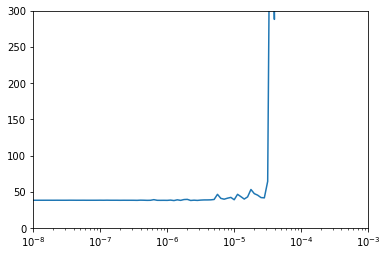

In [28]:
# plot the training loss against the learning rate per epoch
lrs = 1e-8 * (10** (np.arange(100) / 20))
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-8, 1e-3, 0, 300])
plt.show()

Tuning hyperparameter using keras tuner

In [42]:
def build_model(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(
        units=hp.Int('units', min_value=10, max_value=30, step=2),
        activation='relu',
        input_shape=[window_size]
    ))
    model.add(tf.keras.layers.Dense(10, activation='relu'))
    model.add(tf.keras.layers.Dense(1))

    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.SGD(hp.Choice('momentum',
        values=[.9,.7,.5, .3]),
        lr=1e-5
    ))

    return model

In [43]:
import keras_tuner as kt

In [45]:
tuner = kt.RandomSearch(
    build_model,
    objective='loss',
    max_trials=150,
    executions_per_trial=3,
    directory='sequence',
    project_name='sequence_prediction'
)